<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Machine Learning 2025/2026  
## Laboratorio: Funzione di costo, rischio e discesa del gradiente  

**Docente:** Danilo Croce, Giorgio Gambosi

---

### Obiettivi del laboratorio
- Capire cos’è una **funzione di costo (loss function)** e perché è importante.  
- Introdurre il concetto di **rischio** ed **empirical risk**.  
- Vedere in pratica come funziona la **discesa del gradiente (gradient descent)**.  
- Sperimentare su un **dataset semplice** e visualizzare i risultati.  

👉 Questo laboratorio è pensato per **capire le idee di base**, iniziando ad entrare nei dettagli matematici.

## Caricamento delle librerie

Qui importiamo alcune librerie fondamentali:
- **NumPy, Pandas** → per la gestione e manipolazione dei dati
- **Matplotlib** → per produrre grafici
- **SciPy** → per funzioni matematiche avanzate
- **time** → per misurare i tempi di esecuzione

Molte di queste librerie sono già presenti in Colab, mentre in locale potrebbero dover essere installate (ad esempio con `conda install` o `pip install`).

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import scipy.special as sp
import pandas as pd

import time

## Rischio e funzione di costo

- Il nostro obiettivo è addestrare un algoritmo che faccia **previsioni corrette**.
- Per misurare **quanto sbaglia**, usiamo una **funzione di costo (*loss function*)**.
- La loss ci dice “quanto costa” una certa predizione (potenzialmente sbagliata) rispetto al valore corretto.

⚠️ Importante: diverse funzioni di costo possono portare a valutazioni molto diverse.  
La scelta della loss **dipende dal problema e dalle priorità** (ad esempio: meglio evitare falsi positivi o falsi negativi?).

### Rischio e minimizzazione  

Un qualunque algoritmo di apprendimento, dato un input $x$, produce una previsione $f(x)$.  
La qualità di questa previsione può essere valutata tramite una **funzione di costo** (*loss function*) $L(x_1, x_2)$,  
dove:  

- $x_1$ è il valore predetto dal modello,  
- $x_2$ è il valore corretto associato a $x$.  

Il valore $L(f(x),y)$ misura quindi quanto “costa” prevedere $f(x)$ invece del valore corretto $y$.  

---

Dato che il costo dipende dalla coppia $(x,y)$, per valutare in generale la bontà delle predizioni si considera il **valore atteso** della funzione di costo al variare di $x$ e $y$, assumendo una distribuzione di probabilità congiunta $p(x,y)$.  

- $p(x,y)$ rappresenta la probabilità che il prossimo input sia $x$ e che il valore corretto sia $y$.  
- Non si assume che ad uno stesso $x$ corrisponda sempre lo stesso $y$: si considera solo la probabilità condizionata $p(y \mid x)$, in modo da includere anche il **rumore nelle osservazioni**.  

---

Formalmente, indicando con $D_x$ e $D_y$ i domini di $x$ e $y$, il **rischio** $\mathscr{R}$ associato ad un algoritmo $f$ è definito come:

$$
\mathscr{R}(f) = \mathbb{E}_p[L(f(x),y)]
= \int_{D_x}\int_{D_y} L(f(x),y) \, p(x,y) \, dx \, dy
$$

In altre parole, il rischio misura il **costo medio atteso** di utilizzare $f(x)$ per le predizioni.  

---

### Condizioni  
Il rischio è calcolato assumendo che:  

1. $x$ sia estratto casualmente dalla distribuzione marginale  
   $$
   p(x) = \int_{D_y} p(x,y) \, dy
   $$  

2. il valore corretto $y$ sia estratto casualmente dalla distribuzione condizionata  
   $$
   p(y \mid x) = \frac{p(x,y)}{p(x)}
   $$  

3. il costo sia misurato dalla funzione $L(x_1, x_2)$.  

👉 In altre parole, il **rischio** ci dice quanto ci aspettiamo di “pagare” in media se usiamo il modello $f(x)$ per fare previsioni:  

- prendiamo un input $x$ a caso,  
- osserviamo il suo valore corretto $y$,  
- calcoliamo quanto il modello sbaglia con la funzione di costo $L(f(x),y)$,  
- ripetiamo mentalmente questo processo su tutti i possibili $(x,y)$, pesandoli con la loro probabilità $p(x,y)$.  

Il risultato è il **costo medio atteso delle previsioni**.  

#### Esempio: prevedere la pioggia

Immaginiamo di voler prevedere la **possibilità di pioggia** durante la giornata, date le condizioni del cielo al mattino.  
- **Osservazioni possibili**: "sereno" (S), "nuvoloso" (N), "coperto" (C).  
- **Etichette reali**: "pioggia" (T) e "non pioggia" (F).  
- **Predizioni possibili**: "pioggia" (T) e "non pioggia" (F).  

La bontà delle previsioni dipende dalla **funzione di costo** $L:\{T,F\}^2 \mapsto \mathbb{R}$, che assegna un “peso” agli errori.

---

### 1. Funzioni di costo

**Caso 1 – Costi simmetrici**  
Sbagliare in un senso o nell’altro è ugualmente spiacevole:

| $y$/pred |  T   |  F   |
| :------: | :--: | :--: |
|     T    |  0   |  1   |
|     F    |  1   |  0   |

---

**Caso 2 – Costi asimmetrici**  
Bagnarsi è molto peggio che portare l’ombrello inutilmente:

| $y$/pred |  T   |  F   |
| :------: | :--: | :--: |
|     T    |  0   |  1   |
|     F    | 25   |  0   |

---

### 2. Distribuzione congiunta $p(x,y)$

| $x$/$y$ |  T   |  F   |
| :-----: | :--: | :--: |
|    S    | .05  | .20  |
|    N    | .25  | .25  |
|    C    | .20  | .05  |

---

### 3. Modelli predittivi

| $x$  | $f_1(x)$ | $f_2(x)$ |
| :--: | :-------:| :-------: |
|  S   |    F     |    F      |
|  N   |    F     |    T      |
|  C   |    T     |    T      |

---

### 4. Rischio atteso

Il **rischio** di un classificatore $f$ è definito come

$$
\mathscr{R}(f) = \sum_{x}\sum_{y} L(y,f(x)) \; p(x,y)
$$

cioè: la media pesata dei costi, usando le probabilità congiunte.

---

#### 🔹 Calcolo di esempio: $f_1$ con $L_1$

- Per $x=S$: $f_1(S)=F$  
  - se $y=T$: $L(T,F)=1$, peso $p(S,T)=0.05$ → $0.05$  
  - se $y=F$: $L(F,F)=0$, peso $p(S,F)=0.20$ → $0$  

- Per $x=N$: $f_1(N)=F$  
  - se $y=T$: $L(T,F)=1$, peso $p(N,T)=0.25$ → $0.25$  
  - se $y=F$: $L(F,F)=0$, peso $p(N,F)=0.25$ → $0$  

- Per $x=C$: $f_1(C)=T$  
  - se $y=T$: $L(T,T)=0$, peso $p(C,T)=0.20$ → $0$  
  - se $y=F$: $L(F,T)=1$, peso $p(C,F)=0.05$ → $0.05$  

**Totale:**  
$$
\mathscr{R}(f_1,L_1) = 0.05 + 0.25 + 0.05 = 0.35
$$

---

#### 🔹 Risultati riassuntivi

- Con **$L_1$ (costi simmetrici)**:  
  $\mathscr{R}(f_1)=0.35$, $\mathscr{R}(f_2)=0.30$ → **meglio $f_2$**

- Con **$L_2$ (costi asimmetrici)**:  
  $\mathscr{R}(f_1)=5.80$, $\mathscr{R}(f_2)=6.05$ → **meglio $f_1$**

---

### 5. Conclusione

La **scelta del modello migliore** dipende da:  
1. **come pesiamo gli errori** (funzione di costo $L$),  
2. **come sono distribuiti i dati** ($p(x,y)$).  

Se cambiano i pesi o le probabilità, la decisione può ribaltarsi.

### Rischio empirico

La distribuzione reale $p(x,y)$ è sconosciuta (se la conoscessimo potremmo prevedere direttamente $p(y \mid x)$).  
Per questo motivo, il **rischio reale** non è calcolabile, e dobbiamo stimarlo a partire dai dati disponibili.  

L’approccio standard è usare la **media aritmetica sul training set** come stimatore del valore atteso.  
Si definisce quindi il *rischio empirico*:

$$
\overline{\mathscr{R}}(f; X)=\frac{1}{n}\sum_{i=1}^n L(f(x_i),y_i)
$$

dove $X=\{(x_1,y_1),\ldots,(x_n,y_n)\}$ è il training set.  

Il modello scelto sarà quello che **minimizza il rischio empirico**:

$$
f^*=\underset{f\in F}{\mathrm{argmin}}\;\overline{\mathscr{R}}(f;X)
$$

---

In altre parole:  
- si calcola la media degli errori commessi sul training set;  
- si sceglie la funzione $f$ (tra quelle considerate) che produce la media più bassa.  

---

**Fattori che influenzano la bontà di questa approssimazione:**

- **Numero di dati ($n$)**: più il training set è grande, più $\overline{\mathscr{R}}(f;X)$ si avvicina al rischio reale $\mathscr{R}(f)$.  
- **Distribuzione reale $p(x,y)$**: se è molto complessa, servono più dati per stimarla bene.  
- **Funzione di costo $L$**: se assegna costi molto elevati a casi rari, può creare problemi.  
- **Classe di funzioni $F$**:  
  - Se troppo ampia e complessa → servono molti dati per non sovrastimare.  
  - Se troppo ristretta → si rischia di escludere modelli buoni.  

---

### Minimizzazione della funzione di rischio

In generale, l’insieme $F$ delle funzioni può essere descritto in forma **parametrica**:

$$
F=\{f(\mathbf{x};\theta)\}
$$

dove $\theta\in D_\theta$ è un insieme di parametri (spesso un vettore) che specifica una particolare funzione all’interno della famiglia $F$.  

---

**Esempio: regressione lineare**  
Vogliamo prevedere una variabile $y \in \mathbb{R}$ a partire da $m$ attributi $\mathbf{x}=(x_1,\ldots,x_m)$.  
Restringendo $F$ alle sole funzioni lineari, otteniamo:

$$
f_\mathbf{w}(\mathbf{x}) = w_0 + w_1x_1 + \ldots + w_mx_m
$$

dove i parametri sono i coefficienti $\mathbf{w}=(w_0,\ldots,w_m)$.  

---

**Rischio empirico come funzione dei parametri**  

$$
\overline{\mathscr{R}}(\theta; X) = \frac{1}{n}\sum_{i=1}^n L(f(\mathbf{x}_i;\theta),t_i) \qquad f \in F
$$

La minimizzazione del rischio empirico consiste nel trovare i parametri $\theta$ che lo riducono al minimo:

$$
\theta^* = \underset{\theta\in D_\theta}{\mathrm{argmin}}\;\overline{\mathscr{R}}(\theta;X)
$$

Da qui deriva la funzione ottima (all’interno della famiglia $F$):

$$
f^* = f(\mathbf{x};\theta^*)
$$

---

In altre parole:  
- scegliamo una famiglia di funzioni $F$ (es. tutte le rette);  
- valutiamo quanto bene ogni funzione predice i dati (rischio empirico);  
- cerchiamo i **parametri $\theta$ ottimali** che rendono minima la media degli errori.  

Il metodo per eseguire questa minimizzazione può variare a seconda del problema e della complessità del modello (es. metodi analitici, algoritmi numerici, gradient descent, ecc.).

#### Ricerca analitica dell'ottimo

Se il problema si pone come una minimizzazione **senza vincoli** (cioè all’interno di $\mathbb{R}^m$), un primo approccio classico è quello dell’**analisi matematica**:  
cerchiamo i valori $\overline{\theta}$ di $\theta$ per cui si annullano tutte le derivate parziali del rischio empirico.  

In formule:

$$
\frac{\partial \overline{\mathscr{R}}(\theta; X)}{\partial \theta_i}\Big|_{\theta=\overline\theta}=0
\qquad i=1,\ldots,m
$$

dove $m$ è il numero di componenti del vettore $\theta$.  
Questo porta a un sistema di $m$ equazioni con $m$ incognite.  

---

#### Forma compatta: il gradiente
La stessa condizione può essere scritta in forma vettoriale come:

$$
\nabla_\theta\;\overline{\mathscr{R}}(\theta; X)=0
$$

dove $\nabla_\theta$ indica il **gradiente** (cioè il vettore delle derivate parziali rispetto ai parametri).  

---

#### Difficoltà pratiche
- In molti casi la **soluzione analitica** di questo sistema è troppo complessa o addirittura impossibile da calcolare.  
- Inoltre, il gradiente nullo può corrispondere sia a un **minimo locale**, sia a un "**punto di sella**", non necessariamente a un minimo globale.  

Per questi motivi, in pratica si usano spesso **metodi numerici di ottimizzazione** (es. discesa del gradiente, vedi dopo).

### Gradient Descent

La **discesa del gradiente** (*gradient descent*) è una delle tecniche di ottimizzazione più usate nel Machine Learning, soprattutto per addestrare reti neurali.  

L’idea è semplice: vogliamo minimizzare una funzione obiettivo $J(\theta)$, che misura quanto il modello sta sbagliando (ad esempio, la *loss*).  
I parametri del modello $\theta \in \mathbb{R}^d$ vengono aggiornati passo dopo passo, a partire da un valore iniziale $\theta^{(0)}$, muovendosi nella **direzione opposta al gradiente**:

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \cdot \nabla J(\theta^{(k)})
$$

- $\nabla J(\theta)$ = gradiente della funzione (indica la direzione di massima crescita di $J$)  
- $\eta$ = *learning rate*, cioè la dimensione del passo  

---

#### Intuizione
Immagina di essere su una collina al buio e voler scendere a valle:  
- il gradiente ti dice da che parte sale più ripido,  
- quindi muovendoti nella **direzione opposta** scendi più velocemente.  
- la dimensione del passo $\eta$ è come la lunghezza del tuo passo: troppo piccolo → scendi lentamente, troppo grande → rischi di saltare oltre la valle.  

---

👉 Questo metodo è detto di **primo ordine** perché utilizza solo le derivate prime (cioè le pendenze) della funzione da minimizzare.

##### Varianti della discesa del gradiente

Nel Machine Learning, la funzione obiettivo $J(\theta; X)$ si ottiene applicando una *loss function* (funzione di costo) a tutti gli esempi di un dataset $X = \{(\mathbf{x}_1, t_1), \ldots, (\mathbf{x}_n, t_n)\}$.

- $J(\theta; X)$ misura **quanto sbaglia il modello** con i parametri $\theta$.  
- Per semplificare, si calcola come media dei costi sui singoli esempi:

$$
J(\theta;X) = \frac{1}{n}\sum_{i=1}^n J(\theta;\mathbf{x}_i)
$$  

Grazie alle proprietà della derivata, anche il gradiente risulta essere la media dei gradienti sui singoli esempi:  

$$
\nabla J(\theta;X) = \frac{1}{n}\sum_{i=1}^n \nabla J(\theta;\mathbf{x}_i)
$$  

---

### Tre varianti principali
Le varianti della discesa del gradiente dipendono da **quanti esempi del dataset usiamo ad ogni passo** per aggiornare i parametri:

1. **Batch Gradient Descent**  
   - Usa *tutti* i dati ad ogni aggiornamento.  
   - ✅ Aggiornamenti molto accurati  
   - ❌ Può essere **molto lento** (soprattutto con dataset grandi).  

2. **Stochastic Gradient Descent (SGD)**  
   - Usa **un solo esempio alla volta**.  
   - ✅ Aggiornamenti molto veloci  
   - ❌ Molto **rumoroso** (oscilla tanto, non converge in maniera stabile).  

3. **Mini-Batch Gradient Descent**  
   - Compromesso: usa piccoli gruppi (batch) di esempi.  
   - ✅ Equilibrio tra velocità e stabilità  
   - 👉 È lo standard oggi nel Deep Learning.  

---

📌 **In sintesi**:  
- Più esempi → aggiornamento accurato ma lento  
- Meno esempi → aggiornamento veloce ma rumoroso  
- Mini-batch = il miglior compromesso (veloce, scalabile, e abbastanza stabile).

## Let's work

Per capire meglio come funziona la discesa del gradiente, applichiamola ad un semplice problema di **classificazione binaria**.  
Immaginiamo di avere un dataset bidimensionale: ogni punto è descritto da due caratteristiche $(x_1, x_2)$ e da un’etichetta $t \in \{0,1\}$ che indica la classe di appartenenza.  

L’obiettivo è costruire un modello predittivo $f(\mathbf{x}; \theta)$ che, dato un nuovo punto, restituisca un valore vicino a 0 o 1 a seconda della classe.  

---

### La scelta del modello

Partiamo con un modello molto semplice: una **combinazione lineare** delle feature $(x_1, x_2)$ con i parametri $\theta = (\theta_0, \theta_1, \theta_2)$:

$$
z = \theta_0 + \theta_1 x_1 + \theta_2 x_2
$$

Per trasformare $z$ in un valore compreso tra $0$ e $1$ (che possiamo interpretare come probabilità di appartenenza alla classe positiva), applichiamo la **funzione sigmoide**:

$$
f(\mathbf{x}; \theta) = \sigma(z) = \frac{1}{1+e^{-z}}.
$$

👉 Quindi il modello predice la probabilità che l’osservazione appartenga alla classe $1$.  
Solo più avanti vedremo che questa formulazione prende il nome di **logistic regression**.

---

### La funzione di costo: cross-entropy

Per valutare la bontà delle predizioni usiamo la **cross-entropy loss**, che misura quanto la probabilità stimata $f(\mathbf{x};\theta)$ si discosta dal valore vero $t$:

$$
L(t, f(\mathbf{x};\theta)) = - \big[ t \log f(\mathbf{x};\theta) + (1-t)\log(1-f(\mathbf{x};\theta)) \big].
$$

- Se $t=1$, il costo è grande se $f(\mathbf{x};\theta)$ è vicino a 0 (cioè se sbagliamo con alta sicurezza).  
- Se $t=0$, il costo è grande se $f(\mathbf{x};\theta)$ è vicino a 1.  

👉 La cross-entropy penalizza fortemente le previsioni sicure ma sbagliate.

---

### Rischio empirico

Dato un dataset $X = \{(\mathbf{x}_1, t_1), \ldots, (\mathbf{x}_n, t_n)\}$, definiamo il **rischio empirico** come la media delle perdite sui dati:

$$
\mathscr{R}_n(\theta) = \frac{1}{n}\sum_{i=1}^n L\big(t_i, f(\mathbf{x}_i;\theta)\big).
$$

Il nostro obiettivo diventa quindi trovare i parametri $\theta$ che **minimizzano** questo rischio.  

---

### Ottimizzazione: discesa del gradiente

Non possiamo risolvere analiticamente il minimo della funzione, ma possiamo **iterare gli aggiornamenti** dei parametri $\theta$ usando la discesa del gradiente:

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \nabla_\theta \, \mathscr{R}_n(\theta^{(k)}).
$$

- $\eta$ è il *learning rate*, che controlla l’ampiezza dei passi.  
- $\nabla_\theta \, \mathscr{R}_n$ è il gradiente del rischio empirico rispetto ai parametri.  

In pratica:  
- ad ogni passo calcoliamo quanto la funzione di costo “spinge” i parametri in una direzione,  
- ci muoviamo nella direzione opposta per avvicinarci al minimo.  

---

📌 Nei prossimi paragrafi applicheremo il metodo alle tre varianti principali:  
- **Batch Gradient Descent**  
- **Stochastic Gradient Descent (SGD)**  
- **Mini-batch Gradient Descent**

#### Scaricare i dati

Per lavorare su un problema pratico ci serve un **dataset**. In questo laboratorio i dati non sono già presenti dentro Colab, quindi dobbiamo **scaricarli da una sorgente esterna** (in questo caso un link fornito dal docente).

In Colab (e in generale nei notebook Jupyter) il simbolo `!` davanti a un comando permette di eseguire un **comando di shell** direttamente dal notebook, come se fossimo in un terminale Linux.  

- `wget` è un programma da riga di comando che serve per **scaricare file da Internet** (ad esempio dataset, script, immagini).  
- Lo usiamo qui per recuperare il file `testSet.txt` dal link indicato.  

In questo modo il file viene salvato nell’ambiente di esecuzione di Colab e possiamo poi leggerlo con Python (ad esempio con `pandas.read_csv`) ed utilizzarlo per i nostri esperimenti.  

In [ ]:
!wget https://tvml.github.io/ml2425/dataset/testSet.txt


--2025-10-17 08:05:21--  https://tvml.github.io/ml2425/dataset/testSet.txt
Resolving tvml.github.io (tvml.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tvml.github.io (tvml.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2087 (2.0K) [text/plain]
Saving to: ‘testSet.txt’

testSet.txt         100%[===================>]   2.04K  --.-KB/s    in 0s      

2025-10-17 08:05:21 (29.2 MB/s) - ‘testSet.txt’ saved [2087/2087]



Prima di procedere con la costruzione del modello, è utile dare uno sguardo al dataset su cui lavoreremo.  
Il file `testSet.txt` contiene tre colonne:  
- **x1** e **x2**: le due caratteristiche (coordinate) che descrivono ogni punto;  
- **t**: l’etichetta della classe, che può assumere valore 0 o 1.  

Nelle prossime celle mostriamo alcune righe del dataset e la distribuzione delle classi, così da avere un’idea più concreta dei dati su cui applicheremo la discesa del gradiente.

In [ ]:
# Carichiamo il dataset (già scaricato con wget)
data = pd.read_csv("testSet.txt",
                   delim_whitespace=True,
                   header=None,
                   names=['x1','x2','t'])

# Visualizziamo le prime osservazioni
print("Esempi dal dataset:")
display(data.head())

# Controlliamo anche la distribuzione delle classi
print("\nDistribuzione delle etichette:")
display(data['t'].value_counts())

Esempi dal dataset:


/tmp/ipython-input-400570551.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv("testSet.txt",


,x1,x2,t
0,-0.017612,14.053064,0
1,-1.395634,4.662541,1
2,-0.752157,6.538620,0
3,-1.322371,7.152853,0
4,0.423363,11.054677,0



Distribuzione delle etichette:


,count
t,
1,53
0,47


#### Funzioni di Visualizzazione

Per rendere il laboratorio più chiaro, definiamo alcune **funzioni di supporto** che servono a:
- Visualizzare i dati in un grafico 2D
- Tracciare l’andamento della funzione di costo durante l’ottimizzazione
- Mostrare come evolvono i parametri del modello durante il training

👉 Queste funzioni non fanno parte del modello in sé, ma aiutano a **capire cosa succede** in modo visivo.

In [ ]:
colors = ["xkcd:dusty blue", "xkcd:dark peach", "xkcd:dark seafoam green",
          "xkcd:dusty purple","xkcd:watermelon", "xkcd:dusky blue", "xkcd:amber",
          "xkcd:purplish", "xkcd:dark teal", "xkcd:orange", "xkcd:slate"]

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

In [ ]:
def plot_ds(data, m=None, q=None):
    fig = plt.figure(figsize=(16,8))
    x = np.linspace(data.x1.min()*1.1, data.x1.max()*1.1, 1000)
    ax = plt.gca()
    ax.scatter(data[data.t==0].x1, data[data.t==0].x2, s=40, edgecolor='k', alpha=.7)
    ax.scatter(data[data.t==1].x1, data[data.t==1].x2, s=40, edgecolor='k', alpha=.7)
    if (m is not None) and (q is not None):
        ax.plot(x, m*x + q, lw=2)  # colore di default ok
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$'); ax.set_title('Dataset')
    plt.show()

In [ ]:
def plot_all(cost_history, m, q, low=0, high=None, step=1):
    if high is None:
        high = m.shape[0]
    idx = range(low, high, step)
    ch = cost_history[idx].ravel()
    th1 = m[idx]
    th0 = q[idx]

    fig = plt.figure(figsize=(18,6))
    ax = fig.add_subplot(1,2,1)
    ax.plot(range(len(ch)), ch, linewidth=2)
    ax.set_xlabel('iterations'); ax.set_ylabel('cost')
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda x, pos: f'{x*step+low:0.0f}'))

    ax = fig.add_subplot(1,2,2)
    x_min, x_max = th0.min(), th0.max()
    y_min, y_max = th1.min(), th1.max()
    dx, dy = .1*(x_max-x_min+1e-12), .1*(y_max-y_min+1e-12)
    ax.plot(th0, th1, linewidth=2)
    ax.scatter(th0[-1], th1[-1], marker='o', s=40)
    ax.set_xlabel(r'$q$'); ax.set_ylabel(r'$m$')
    ax.set_xlim(x_min-dx, x_max+dx); ax.set_ylim(y_min-dy, y_max+dy)
    plt.tight_layout(); plt.show()

Per visualizzare meglio la natura del problema, rappresentiamo i punti del dataset nel piano delle caratteristiche $(x_1, x_2)$.  
Ogni punto è colorato in base alla sua etichetta $t$:  
- un colore per la **classe 0**  
- un colore diverso per la **classe 1**  

In questo modo possiamo osservare come i dati siano distribuiti e intuire la possibilità di separarli mediante una retta.

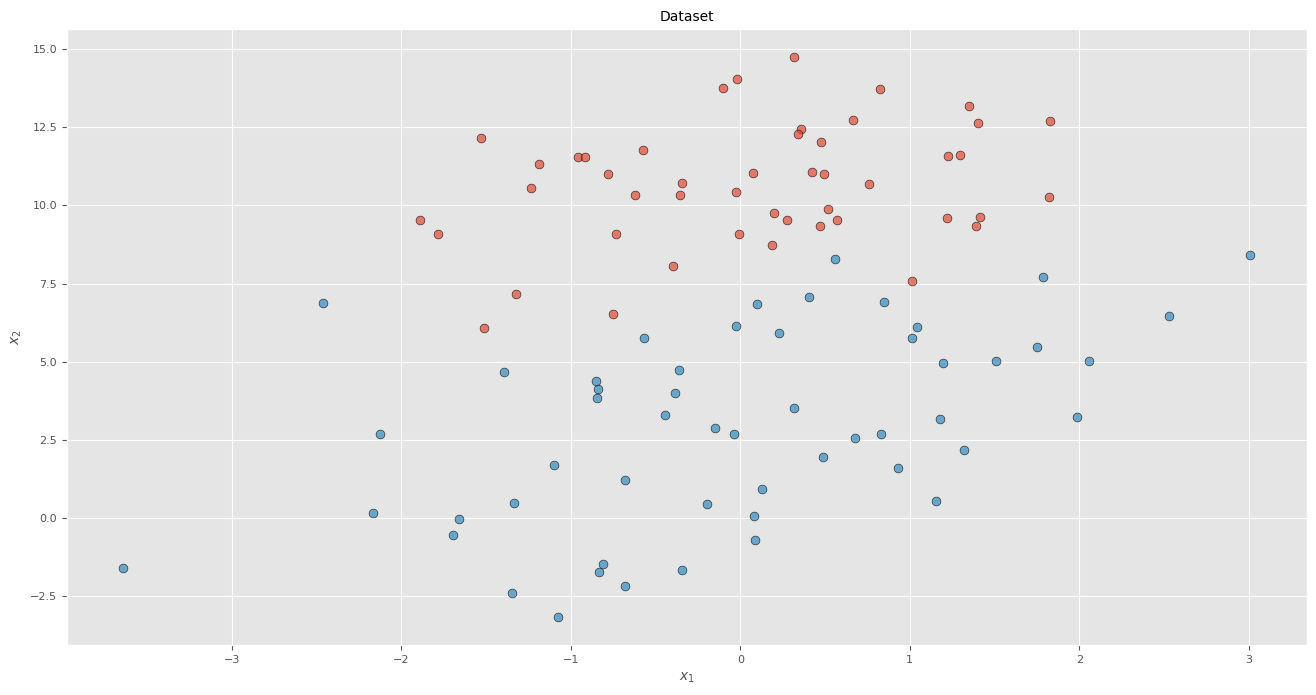

In [ ]:
plot_ds(data)

## Verso la discesa del gradiente

Una volta definita la funzione di rischio empirico $\mathscr{R}_n(\theta)$, il passo successivo è capire **come modificarla** per trovare i parametri $\theta$ che la minimizzano.

---

### 1️⃣ I parametri del modello

Indichiamo con $\theta = (\theta_0, \theta_1, \theta_2)$ il vettore dei **parametri** del modello.  
Nel nostro caso, essi determinano la retta che separa le due classi nel piano delle feature $(x_1, x_2)$:

$$
z = \theta_0 + \theta_1 x_1 + \theta_2 x_2
$$

La funzione del modello, che restituisce la probabilità stimata di appartenere alla classe positiva, è:

$$
f(\mathbf{x}; \theta) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

### 2️⃣ La funzione di costo

Per misurare la bontà delle predizioni del modello utilizziamo la **cross-entropy loss**:

$$
L(t, f(\mathbf{x};\theta)) = -\big[t \log f(\mathbf{x};\theta) + (1-t)\log(1-f(\mathbf{x};\theta))\big]
$$

dove:
- $t \in \{0,1\}$ è il **valore reale** (target) associato al campione $\mathbf{x}$;  
- $f(\mathbf{x};\theta)$ è la **predizione del modello**, ovvero la probabilità stimata che $\mathbf{x}$ appartenga alla classe positiva.


Di conseguenza, il **rischio empirico medio** su \(n\) osservazioni diventa:

$$
\mathscr{R}_n(\theta) = \frac{1}{n}\sum_{i=1}^n L(t_i, f(\mathbf{x}_i; \theta)).
$$

---

### 3️⃣ Il gradiente del rischio

Per minimizzare $\mathscr{R}_n(\theta)$ dobbiamo calcolare **come cambia** la funzione di costo media rispetto ai parametri $\theta = (\theta_0, \theta_1, \theta_2)$.

Il **gradiente** è il vettore delle derivate parziali:

$$
\nabla_\theta \mathscr{R}_n(\theta) =
\begin{bmatrix}
\frac{\partial \mathscr{R}_n}{\partial \theta_0} \\
\frac{\partial \mathscr{R}_n}{\partial \theta_1} \\
\frac{\partial \mathscr{R}_n}{\partial \theta_2}
\end{bmatrix}.
$$

---

#### 🔹 Partiamo dalla funzione di costo media

$$
\mathscr{R}_n(\theta)
= -\frac{1}{n}\sum_{i=1}^n \Big[t_i \log f_i + (1-t_i)\log(1-f_i)\Big],
\qquad f_i = \sigma(z_i) = \frac{1}{1+e^{-z_i}}, \quad z_i = \theta^\top \mathbf{x}_i.
$$

---

#### 🔹 Deriviamo rispetto a $\theta_j$

Applichiamo la *chain rule*:

$$
\frac{\partial \mathscr{R}_n}{\partial \theta_j}
= -\frac{1}{n}\sum_{i=1}^n
\Bigg[
\frac{t_i}{f_i} \frac{\partial f_i}{\partial \theta_j}
- \frac{1-t_i}{1-f_i} \frac{\partial f_i}{\partial \theta_j}
\Bigg].
$$

Poiché $\frac{\partial f_i}{\partial \theta_j} = f_i(1-f_i)x_{ij}$ (derivata della sigmoide),
otteniamo:

$$
\frac{\partial \mathscr{R}_n}{\partial \theta_j}
= -\frac{1}{n}\sum_{i=1}^n (t_i - f_i)x_{ij}.
$$

---

#### 🔹 Forma vettoriale compatta

Scrivendo tutte le derivate insieme in forma matriciale, il risultato diventa:

$$
\nabla_\theta \mathscr{R}_n(\theta)
= -\frac{1}{n} X^\top (t - f(\theta, X)),
$$

dove:

- $X$ è la matrice delle feature (con la colonna di 1 per il bias),  
- $t$ è il vettore colonna dei valori target,  
- $f(\theta, X)$ è il vettore delle probabilità predette $\sigma(X\theta)$.

---

#### 🔹 Interpretazione intuitiva

- $(t - f)$ è l’**errore di predizione**: quanto il modello sbaglia per ciascun esempio.  
- Moltiplicare per $X^\top$ propaga l’effetto di ogni errore sulle rispettive feature.  
- Il fattore $1/n$ calcola la **media** dei contributi di tutti i campioni.

👉 In breve:  
il gradiente ci dice **in che direzione** la funzione di costo cresce più rapidamente;  
muovendoci nella direzione opposta, la funzione **diminuisce più velocemente** (discesa del gradiente).


In [ ]:
# 1️⃣ Funzione del modello (sigmoide logistica)
def f(theta, X):
    """
    Calcola le probabilità predette dal modello.

    f(x; θ) = σ(θᵀx) = 1 / (1 + e^(-θᵀx))

    Dove:
    - θ è il vettore dei parametri (bias + pesi)
    - X è la matrice dei dati (con una colonna di 1 per il bias)
    - σ è la funzione sigmoide logistica

    La sigmoide converte la combinazione lineare z = θᵀx
    in un valore compreso tra 0 e 1, interpretabile come probabilità
    che il campione appartenga alla classe positiva (t = 1).

    Usiamo scipy.special.expit(z) invece di 1/(1+exp(-z))
    perché è una versione numericamente stabile che evita overflow.
    """
    z = np.dot(X, theta)              # combinazione lineare delle feature
    return sp.expit(z).reshape(-1, 1) # applica la sigmoide logistica

# 2️⃣ Funzione di costo (cross-entropy)
def cost(theta, X, t):
    """
    Calcola la *cross-entropy loss* media sul dataset.

    L(t, f(x;θ)) = - [ t log(f(x;θ)) + (1 - t) log(1 - f(x;θ)) ]

    Questa misura penalizza fortemente le previsioni errate
    fatte con alta sicurezza (valori di f(x;θ) molto vicini a 0 o 1).

    Parametri:
    - θ: vettore dei parametri del modello
    - X: matrice dei dati (n x d)
    - t: vettore delle etichette (n x 1), con valori 0 o 1

    Nota numerica:
    Per evitare errori di log(0), i valori di f(x;θ) sono "clippati"
    in un intervallo [eps, 1 - eps].
    """
    eps = 1e-15  # piccolo valore per evitare log(0)
    v = np.clip(f(theta, X), eps, 1 - eps)
    term1 = np.dot(np.log(v).T, t)
    term2 = np.dot(np.log(1 - v).T, (1 - t))
    return ((-term1 - term2) / len(X))[0]


# 3️⃣ Gradiente della funzione di costo
def gradient(theta, X, t):
    """
    Calcola il gradiente della funzione di costo rispetto ai parametri θ.

    ∇θ J(θ) = - (1/n) * Xᵀ (t - f(θ, X))

    Dove:
    - (t - f(θ, X)) rappresenta l'errore di predizione su ogni campione
    - Xᵀ (t - f) propaga questi errori pesandoli in base alle feature
    - La divisione per n restituisce la media del gradiente sul dataset

    Il gradiente indica la direzione di massima crescita della funzione
    di costo: per minimizzarla, durante la discesa del gradiente ci muoviamo
    nella direzione opposta a questo vettore.
    """
    return -np.dot(X.T, (t - f(theta, X))) / len(X)

## Preparazione dei dati

Prima di applicare i metodi di ottimizzazione, dobbiamo preparare il dataset in una forma adatta al calcolo numerico.

Il file `testSet.txt` contiene tre colonne:
- **x1**, **x2** → le due caratteristiche (feature) che descrivono ciascun campione;
- **t** → l’etichetta di classe (0 o 1).

---

### 1️⃣ Caricamento dei dati
Utilizziamo la libreria `pandas` per leggere il file di testo e creare un DataFrame.  
Questo ci permette di ispezionare facilmente i dati e di convertirli in array NumPy per le operazioni successive.

---

### 2️⃣ Costruzione delle variabili

- **`X`** → matrice delle feature, con due colonne (x1, x2);  
- **`t`** → vettore colonna con le etichette di classe;  
- **`X` con bias** → aggiungiamo una colonna di 1 per gestire il termine noto (bias) nel modello lineare.

In pratica:
$$
X =
\begin{bmatrix}
1 & x_{11} & x_{12} \\
1 & x_{21} & x_{22} \\
\vdots & \vdots & \vdots \\
1 & x_{n1} & x_{n2}
\end{bmatrix},
\qquad
t =
\begin{bmatrix}
t_1 \\ t_2 \\ \vdots \\ t_n
\end{bmatrix}
$$

---

### 3️⃣ Output
Al termine, otteniamo:
- `n` → numero di esempi nel dataset,  
- `nfeatures` → numero di feature per esempio,  
- `X` e `t` pronti per essere utilizzati negli algoritmi di ottimizzazione.

In [ ]:
# Dimensioni del dataset
n = len(data)
nfeatures = len(data.columns) - 1  # due feature: x1, x2

# Costruiamo X e t
X = np.array(data[['x1', 'x2']])
t = np.array(data['t']).reshape(-1, 1)

# Aggiungiamo una colonna di 1 per il bias
X = np.column_stack((np.ones(n), X))

print(f"Numero di campioni: {n}")
print(f"Numero di feature: {nfeatures}")
print(f"Forma di X: {X.shape}")
print(f"Forma di t: {t.shape}")

Numero di campioni: 100
Numero di feature: 2
Forma di X: (100, 3)
Forma di t: (100, 1)


## Batch Gradient Descent

Il **Batch Gradient Descent (BGD)** è la forma “classica” della discesa del gradiente.  
Ad ogni iterazione, il gradiente viene calcolato **su tutto il dataset** e utilizzato per aggiornare i parametri $\theta$.

---

### 1️⃣ Idea di base

Ad ogni passo $k$, aggiorniamo i parametri muovendoci **nella direzione opposta al gradiente** del rischio empirico:

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \, \nabla_\theta J(\theta^{(k)}; X)
$$

dove:
- $\eta$ è il **learning rate**, che controlla la dimensione del passo,
- $\nabla_\theta J(\theta; X)$ è il gradiente della funzione di costo sul dataset.

Poiché il gradiente viene calcolato su **tutti** gli esempi, l’aggiornamento è accurato ma **computazionalmente costoso** (immaginate avere milioni di esempi, tutti contemporaneamente in memoria).

---

### 2️⃣ Dettagli operativi

Nel nostro caso, la funzione di costo è la *cross-entropy*, e il gradiente è:

$$
\nabla_\theta J(\theta; X) = -\frac{1}{n} X^\top (t - f(\theta, X))
$$

Pertanto, l’aggiornamento dei parametri ad ogni iterazione è:

$$
\theta^{(k+1)} = \theta^{(k)} + \frac{\eta}{n} X^\top (t - f(\theta^{(k)}, X))
$$

**Nota 🧩**  
Nel seguito useremo le notazioni $J(\theta)$ e $\mathscr{R}_n(\theta)$ in modo equivalente:  
$J(\theta)$ rappresenta la **funzione obiettivo** da minimizzare,  
mentre $\mathscr{R}_n(\theta)$ è la sua **forma esplicita** come rischio empirico  
(media delle perdite sul dataset di training).

---

### 3️⃣ Interpretazione

- Il termine $(t - f(\theta, X))$ rappresenta l’**errore di predizione** del modello.
- Moltiplicando per $X^\top$ si pesano gli errori in base alle feature.
- La divisione per $n$ garantisce che l’aggiornamento sia la **media** degli effetti dei singoli esempi.

---

### 4️⃣ Procedura complessiva

1. Inizializzare i parametri $\theta$ a zero (o piccoli valori casuali).  
2. Ripetere per un certo numero di **epoche**:
   - Calcolare il gradiente su tutto il dataset,
   - Aggiornare $\theta$ muovendosi nella direzione opposta,
   - Salvare i valori di $\theta$ e del costo per analizzare la convergenza.

---

👉 In sintesi:
- **Pro**: aggiornamenti stabili, andamento regolare della funzione di costo;
- **Contro**: lento su dataset grandi, ogni iterazione richiede di scorrere tutti i dati.

In [ ]:
def batch_gd(X, t, eta=0.1, epochs=10000):
    """
    Implementa il Batch Gradient Descent (BGD) per la regressione logistica.

    Ad ogni iterazione:
    - calcola il gradiente della funzione di costo su *tutto il dataset*;
    - aggiorna i parametri θ nella direzione opposta al gradiente;
    - salva i valori di θ e della funzione di costo per analizzare la convergenza.

    Parametri:
    ----------
    X : ndarray (n x d)
        Matrice dei dati (inclusa la colonna di 1 per il bias).
    t : ndarray (n x 1)
        Vettore delle etichette (0 o 1).
    eta : float
        Learning rate — controlla la dimensione dei passi.
    epochs : int
        Numero totale di iterazioni (passate su tutto il dataset).

    Ritorna:
    --------
    cost_history : ndarray
        Valori della funzione di costo a ogni iterazione.
    theta_history : ndarray
        Valori dei parametri θ a ogni passo.
    m, q : ndarray
        Pendenza e intercetta della retta di separazione nel piano (x1, x2).
    """

    # 1️⃣ Inizializzazione dei parametri del modello (bias + 2 pesi)
    theta = np.zeros(nfeatures + 1).reshape(-1, 1)

    # Liste per memorizzare l’evoluzione dei parametri e del costo
    theta_history = []
    cost_history = []

    # 2️⃣ Ciclo principale di ottimizzazione
    for k in range(epochs):
        # Calcolo del gradiente sul dataset completo
        grad = gradient(theta, X, t)

        # Aggiornamento dei parametri (discesa nella direzione opposta al gradiente)
        delta = -eta * grad
        theta = theta + delta

        # Salvataggio dello stato corrente (per analisi successive)
        theta_history.append(theta)
        cost_history.append(cost(theta, X, t))

    # 3️⃣ Conversione in array NumPy per elaborazioni successive
    theta_history = np.array(theta_history).reshape(-1, 3)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # 4️⃣ Estrazione di m e q (parametri della retta di separazione nel piano dei dati)
    m = -theta_history[:, 1] / theta_history[:, 2]
    q = -theta_history[:, 0] / theta_history[:, 2]

    # Ritorno dei risultati
    return cost_history, theta_history, m, q

## Applicazione del Batch Gradient Descent

Ora possiamo mettere in pratica il metodo **Batch Gradient Descent (BGD)** sul dataset preparato.

---

### 1️⃣ Parametri di addestramento

Per eseguire il metodo, dobbiamo scegliere:
- **Learning rate** $\eta$: controlla la velocità di aggiornamento dei parametri.  
  - Un valore troppo piccolo → convergenza lenta  
  - Un valore troppo grande → oscillazioni o divergenza  
- **Numero di epoche**: quante volte scansioniamo tutto il dataset.

---

### 2️⃣ Esecuzione

Durante l’addestramento:
- ad ogni iterazione, si calcola il gradiente sull’intero dataset;
- si aggiornano i parametri $\theta$;
- si salvano i valori della funzione di costo e dei parametri per analizzare la convergenza.

---

### 3️⃣ Analisi dei risultati

Dopo il training:
- osserviamo il tempo di esecuzione,
- il numero di iterazioni effettuate,
- la discesa della funzione di costo nel tempo,
- e la traiettoria dei coefficienti della retta di separazione nel piano dei parametri $(m, q)$.

L’andamento regolare del costo mostra la **convergenza stabile** tipica del *Batch Gradient Descent*.

Tempo di esecuzione (Batch GD): 0.180 s
1000 passi effettuati (1000 epoche)
1000 gradienti calcolati (1 per passo)
Valore finale della funzione di costo: 0.1530


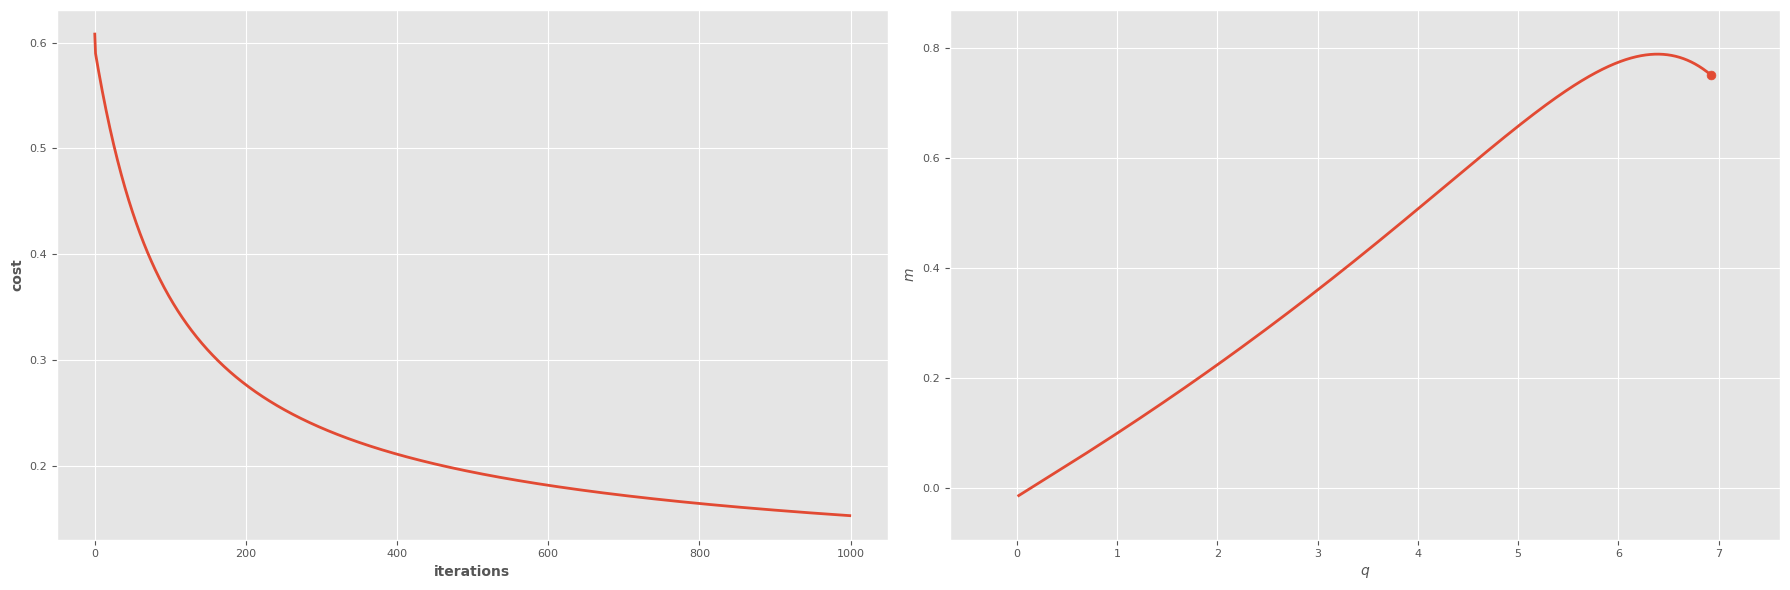

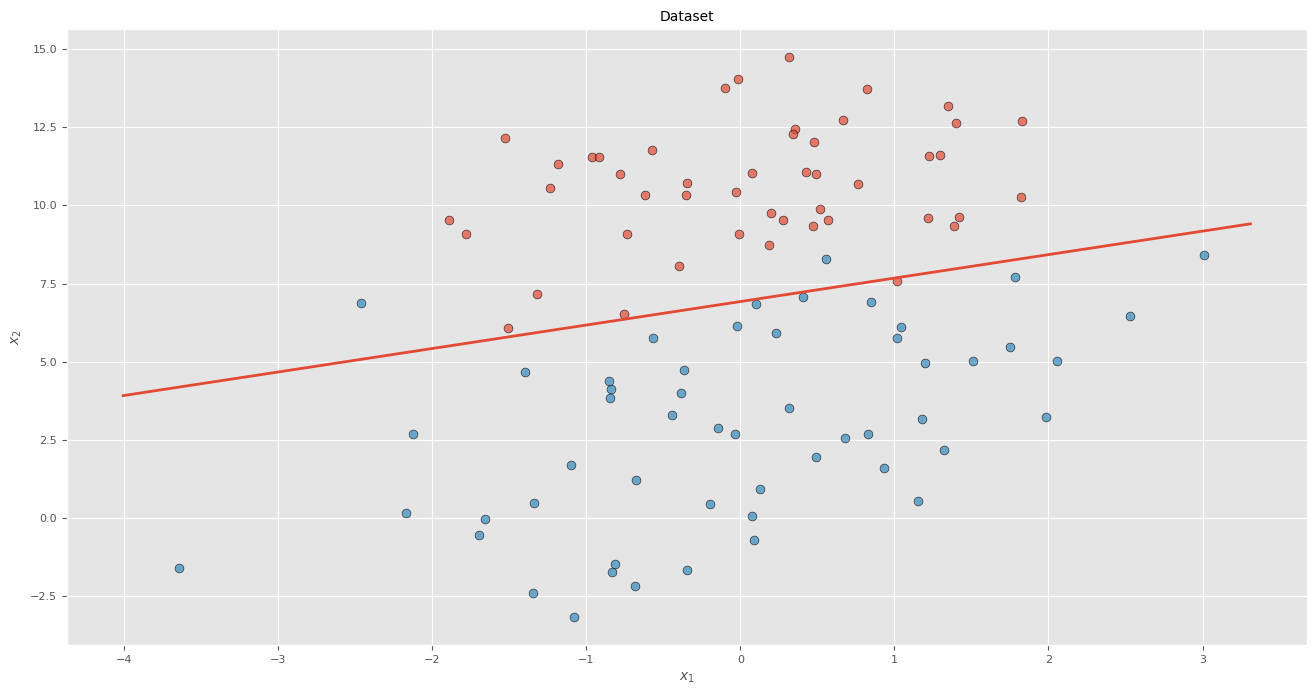

Valori stimati (Batch GD): m = 0.75120, q = 6.92272


In [ ]:
# ===============================================================
# 🧩 1️⃣ Batch Gradient Descent
# ===============================================================
# In questo caso il gradiente viene calcolato su TUTTO il dataset
# a ogni iterazione (una sola volta per epoca).
# ===============================================================

epochs = 1000  # stesso numero per tutti i metodi

# ⏱️ Avvio del training
start_time = time.time()
cost_history_batch, theta_history_batch, m_batch, q_batch = batch_gd(X, t, eta=0.1, epochs=epochs)
time_batch = time.time() - start_time

# 📊 Risultati principali
print(f"Tempo di esecuzione (Batch GD): {time_batch:4.3f} s")
print(f"{len(m_batch)} passi effettuati ({epochs} epoche)")
print(f"{len(m_batch)} gradienti calcolati (1 per passo)")
print(f"Valore finale della funzione di costo: {cost_history_batch[-1][0]:.4f}")

# 📈 Andamento della funzione di costo e traiettoria dei parametri
plot_all(cost_history_batch, m_batch, q_batch)

# 🔹 Retta di separazione finale sul dataset
plot_ds(data, m_batch[-1], q_batch[-1])

# 🔹 Visualizzazione dei valori ottimi stimati
print(f"Valori stimati (Batch GD): m = {m_batch[-1]:4.5f}, q = {q_batch[-1]:4.5f}")

## Considerazioni sul Batch Gradient Descent

L’andamento del **Batch Gradient Descent (BGD)** è caratterizzato da una discesa regolare e stabile della funzione di costo, segno di una **convergenza controllata** verso un minimo.

---

### 🔹 Comportamento tipico

Osservando il grafico della funzione di costo $J(\theta)$:
- si nota una **decrescita monotona** fino a stabilizzarsi in prossimità del minimo locale;
- la traiettoria dei parametri $(m, q)$ nello spazio dei coefficienti mostra un percorso **graduale e diretto** verso la soluzione ottimale $(m^*, q^*)$.

Questo riflette il fatto che, ad ogni iterazione, l’algoritmo usa **tutte le informazioni disponibili** del dataset per stimare la direzione di discesa più accurata possibile.

---

### ⚙️ Vantaggi

- **Stabilità**: la funzione di costo decresce in modo regolare, senza oscillazioni improvvise.  
- **Precisione**: ogni aggiornamento tiene conto di tutto il dataset, garantendo una direzione di discesa corretta.  
- **Convergenza garantita** (se la funzione è convessa):  
  - per funzioni convex $J(\theta)$ → raggiunge il minimo globale;  
  - per funzioni non convex (es. reti neurali) → raggiunge un minimo locale stabile.

---

### ⚠️ Limiti

- **Costo computazionale elevato**: ad ogni passo, il gradiente viene calcolato su tutti i $n$ campioni del dataset.  
  👉 Questo diventa proibitivo per dataset molto grandi (Deep Learning, Big Data).  
- **Memoria**: l’intero dataset deve essere caricato in RAM per calcolare il gradiente.  
- **Lentezza di aggiornamento**: i parametri si aggiornano solo una volta per epoca, quindi la convergenza può richiedere molto tempo.

---

### 💡 Interpretazione pratica

Il *Batch Gradient Descent* è un ottimo punto di partenza per:
- capire **come funziona l’ottimizzazione** basata sul gradiente;
- visualizzare il concetto di discesa “dolce” e sistematica verso il minimo;
- confrontarlo successivamente con metodi più efficienti (*Stochastic* e *Mini-Batch*).

---

📌 In sintesi:
- Il BGD è **preciso ma lento**.  
- È ideale per problemi **piccoli o teorici**, ma poco adatto a dataset di grandi dimensioni.  
- Le varianti successive (*SGD* e *Mini-Batch*) mantengono la stessa idea di fondo, ma con compromessi diversi tra **velocità**, **stabilità** e **accuratezza**.

---

## Stochastic Gradient Descent (SGD)

Dopo aver analizzato il *Batch Gradient Descent*, passiamo a una sua variante più “agile”: la **Stochastic Gradient Descent (SGD)**.  

---

### 🔹 Idea di base

Nel *Batch Gradient Descent*, il gradiente viene calcolato ad ogni iterazione usando **tutti gli esempi** del dataset.  
Questo garantisce stabilità, ma è computazionalmente costoso.

La **Stochastic Gradient Descent** risolve il problema aggiornando i parametri **dopo ogni singolo esempio**.  
In pratica:
- il gradiente viene calcolato su **un solo punto alla volta**;
- i parametri $\theta$ vengono aggiornati **immediatamente**.

Matematicamente:

$$
\theta^{(k+1)} = \theta^{(k)} - \eta \, \nabla_\theta J\big(\theta^{(k)}; \mathbf{x}_i\big)
$$

dove $\mathbf{x}_i$ è il singolo campione scelto all’iterazione corrente.

---

### ⚙️ Procedura di aggiornamento

Per ogni epoca:
1. si mescola il dataset (per evitare effetti dovuti all’ordine dei dati);
2. per ogni esempio $\mathbf{x}_i$:
   - si calcola il gradiente della *loss* su quell’esempio;
   - si aggiornano immediatamente i parametri $\theta$.

---

### 🧩 Effetti pratici

- Gli aggiornamenti frequenti rendono il metodo **molto più veloce**.  
- Tuttavia, il gradiente stimato su un solo esempio è **rumoroso**: la traiettoria di discesa non è regolare ma “zigzagante”.

La funzione di costo mostra tipicamente **oscillazioni** attorno a un trend decrescente.  
Questo rumore, però, può essere utile: permette al metodo di **uscire da minimi locali** e continuare la ricerca di soluzioni migliori.

---

### 🔸 Aggiornamento dei parametri nella classificazione binaria

Nel nostro caso (funzione sigmoide e loss di tipo cross-entropy):

\begin{align*}
\theta_j^{(k+1)} &= \theta_j^{(k)} + \eta (t_i - f(\mathbf{x}_i; \theta^{(k)})) x_{ij} \quad \text{per } j=1,\ldots,d \\
\theta_0^{(k+1)} &= \theta_0^{(k)} + \eta (t_i - f(\mathbf{x}_i; \theta^{(k)}))
\end{align*}

Ogni campione contribuisce subito a correggere i pesi in base all’errore di predizione.  
Nel tempo, gli aggiornamenti si “bilanciano”, e $\theta$ converge verso una soluzione stabile.

---

📘 In sintesi:

| Caratteristica | Batch GD | Stochastic GD |
|----------------|-----------|---------------|
| Aggiornamento  | dopo ogni epoca | dopo ogni campione |
| Stabilità      | alta | bassa (rumore elevato) |
| Velocità       | lenta | veloce |
| Scalabilità    | bassa | ottima |
| Adatto a       | dataset piccoli | dataset grandi |

Il comportamento oscillante è il prezzo da pagare per l’efficienza e la scalabilità.

In [ ]:
def stochastic_gd(X, t, eta=0.01, epochs=1000):
    """
    Implementa lo Stochastic Gradient Descent (SGD) per la regressione logistica.

    A differenza del Batch Gradient Descent, qui il gradiente viene calcolato
    e applicato su **un solo campione alla volta**, aggiornando i parametri
    immediatamente dopo ogni esempio.

    Monitoraggio:
    - Per visualizzare l'andamento della funzione di costo, la 'loss'
      viene calcolata sull'INTERO dataset (X, t) e salvata in cost_history.
    - ⚠️ Attenzione: questo NON influisce sull'aggiornamento, serve solo a tracciare la curva di convergenza.

    Parametri:
    ----------
    X : ndarray (n x d)
        Matrice dei dati (con colonna di 1 per il bias).
    t : ndarray (n x 1)
        Vettore delle etichette (0 o 1).
    eta : float
        Learning rate — controlla l’ampiezza del passo di aggiornamento.
    epochs : int
        Numero di epoche (ogni epoca scansiona tutto il dataset una volta).

    Ritorna:
    --------
    cost_history : ndarray
        Valori della funzione di costo durante l’addestramento.
    theta_history : ndarray
        Valori dei parametri θ ad ogni aggiornamento.
    m, q : ndarray
        Pendenza e intercetta della retta di separazione nel piano (x1, x2).
    """

    # 1️⃣ Inizializzazione dei parametri del modello
    theta = np.zeros(nfeatures + 1).reshape(-1, 1)

    # Liste per tenere traccia dell’evoluzione dei parametri e del costo
    theta_history = []
    cost_history = []

    # 2️⃣ Ciclo principale su tutte le epoche
    for j in range(epochs):

        # (opzionale ma consigliato) — mescoliamo i dati a ogni epoca
        # per evitare che l’ordine degli esempi influenzi l’apprendimento
        idx = np.random.permutation(len(X))
        X, t = X[idx], t[idx]

        # 3️⃣ Aggiornamento dei parametri per ogni campione
        for i in range(n):
            # Calcola il gradiente rispetto al singolo campione (riga X[i])
            grad_i = gradient(theta, X[i, :].reshape(1, -1), t[i])

            # Aggiorna immediatamente i parametri nella direzione opposta al gradiente
            theta = theta - eta * grad_i

            # Salva lo stato corrente
            theta_history.append(theta)
            cost_history.append(cost(theta, X, t))  # costo calcolato sull’intero dataset

    # 4️⃣ Conversione dei risultati in array per analisi successive
    theta_history = np.array(theta_history).reshape(-1, 3)
    cost_history = np.array(cost_history).reshape(-1, 1)

    # 5️⃣ Calcolo della pendenza e intercetta della retta di separazione
    m = -theta_history[:, 1] / theta_history[:, 2]
    q = -theta_history[:, 0] / theta_history[:, 2]

    return cost_history, theta_history, m, q

## Applicazione dello Stochastic Gradient Descent

Tempo di esecuzione (SGD): 8.895 s
100000 passi effettuati (1000 epoche)
100000 gradienti calcolati (1 per passo, su singoli esempi)
Valore finale della funzione di costo: 0.0987


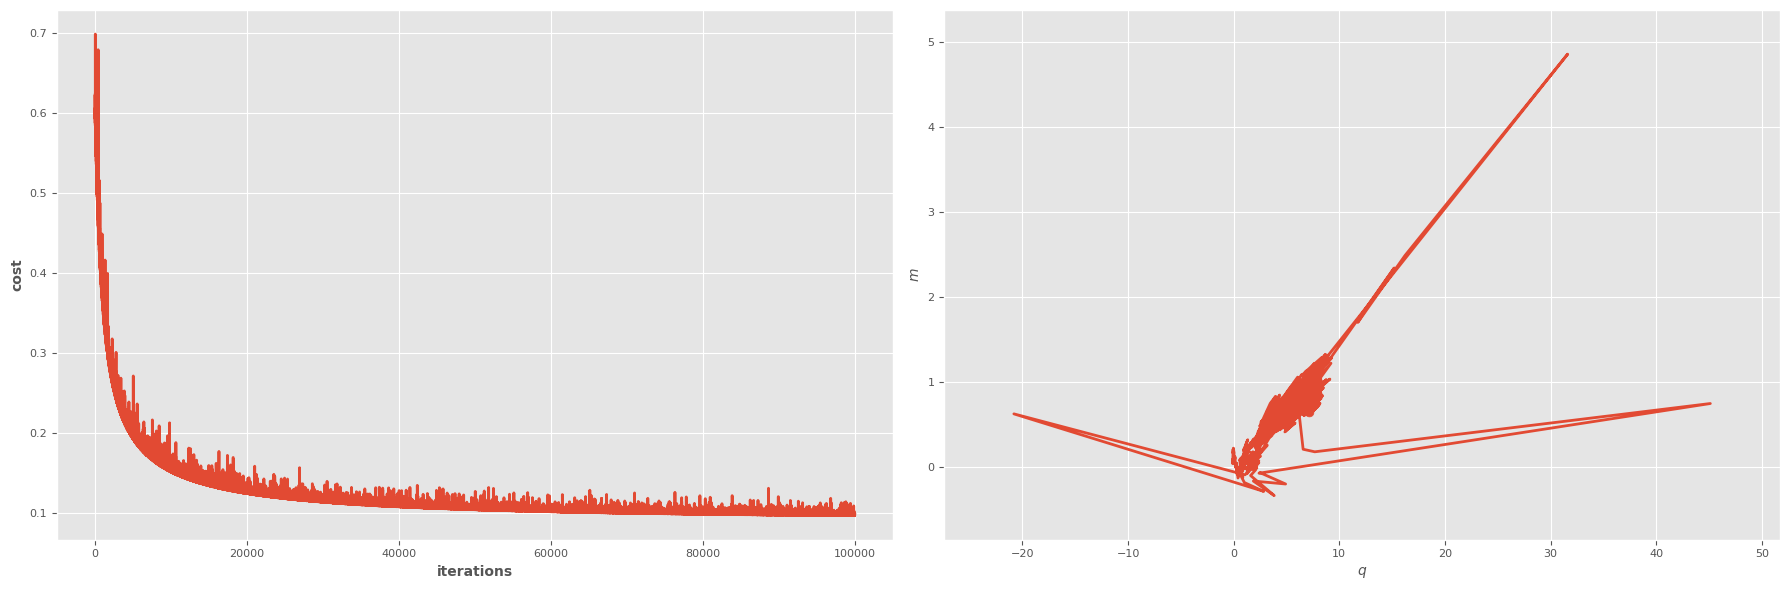

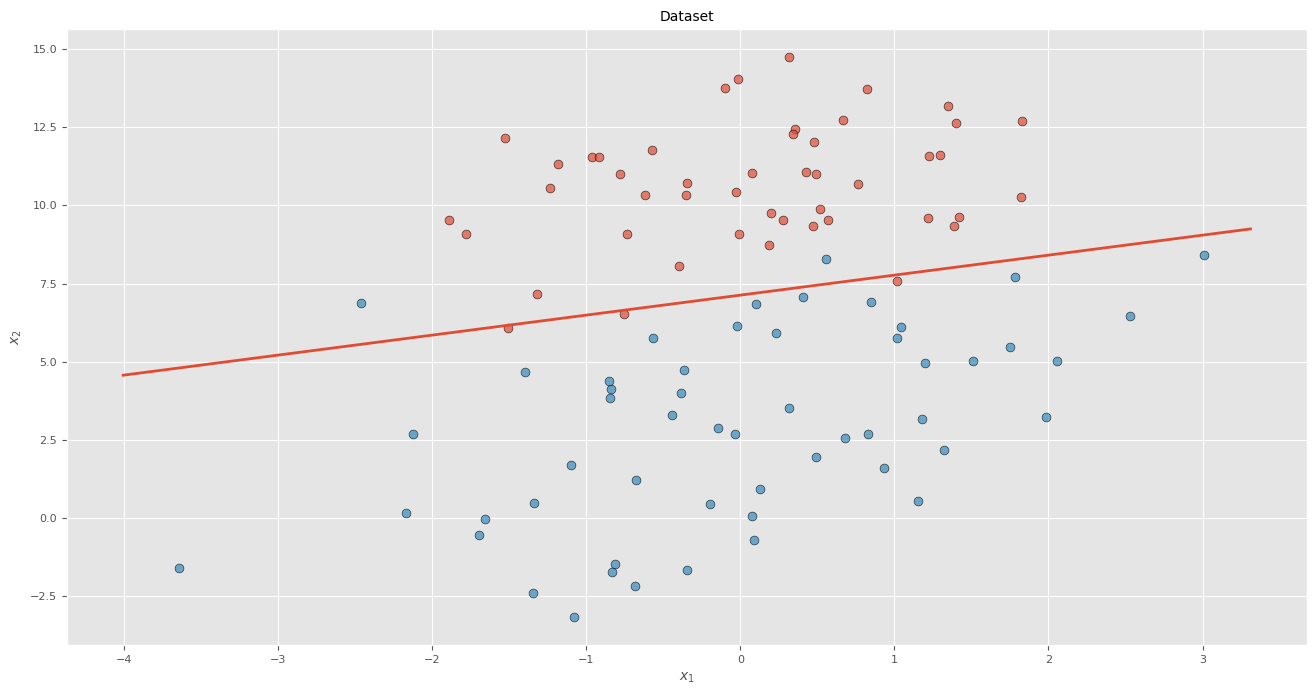

Valori stimati (SGD): m = 0.63969, q = 7.12880


In [ ]:
# ===============================================================
# 🧩 2️⃣ Stochastic Gradient Descent (SGD)
# ===============================================================
# Qui il gradiente è calcolato su un solo campione per volta.
# Ciò comporta molti più aggiornamenti dei parametri, ma più rumorosi.
# ===============================================================

start_time = time.time()
cost_history_sgd, theta_history_sgd, m_sgd, q_sgd = stochastic_gd(X, t, eta=0.01, epochs=epochs)
time_sgd = time.time() - start_time

# 📊 Risultati principali
print(f"Tempo di esecuzione (SGD): {time_sgd:4.3f} s")
print(f"{len(m_sgd)} passi effettuati ({epochs} epoche)")
print(f"{len(m_sgd)} gradienti calcolati (1 per passo, su singoli esempi)")
print(f"Valore finale della funzione di costo: {cost_history_sgd[-1][0]:.4f}")

# 📈 Andamento della funzione di costo e traiettoria dei parametri
plot_all(cost_history_sgd, m_sgd, q_sgd)

# 🔹 Retta di separazione finale sul dataset
plot_ds(data, m_sgd[-1], q_sgd[-1])

# 🔹 Visualizzazione dei valori ottimi stimati
print(f"Valori stimati (SGD): m = {m_sgd[-1]:4.5f}, q = {q_sgd[-1]:4.5f}")

## Considerazioni sullo Stochastic Gradient Descent

Il comportamento osservato è molto diverso rispetto al *Batch Gradient Descent*.

---

### 🔹 Caratteristiche osservate

- La funzione di costo **oscilla** durante l’addestramento, ma mostra un **trend complessivamente decrescente**.  
- I parametri $(m, q)$ seguono una traiettoria irregolare, ma tendono a stabilizzarsi in prossimità del minimo.  
- Il metodo converge rapidamente verso una buona soluzione, anche se meno precisa del caso batch.

---

### 🔸 Vantaggi

- **Efficienza**: ogni aggiornamento usa solo un campione → perfetto per dataset grandi.  
- **Scalabilità**: adatto a flussi di dati continui (*online learning*).  
- **Flessibilità**: l’aggiornamento immediato può aiutare a uscire dai minimi locali.

---

### ⚠️ Limiti

- **Oscillazioni**: la discesa non è regolare, e la funzione di costo può anche aumentare localmente.  
- **Rumore**: il gradiente stimato su un singolo campione è poco accurato.  
- **Scelta sensibile di $\eta$**: un learning rate troppo grande può causare divergenza.

---

📘 **In sintesi:**
Lo *Stochastic Gradient Descent* è un metodo **più reattivo e scalabile**, ideale per problemi di grandi dimensioni.  
Pur introducendo rumore e oscillazioni, rappresenta un passo fondamentale verso le varianti moderne (come *Mini-Batch*, *Momentum*, e *Adam*), che mirano a combinare **efficienza** e **stabilità**.

---

## Mini-Batch Gradient Descent

Il **Mini-Batch Gradient Descent (MBGD)** rappresenta un compromesso efficace tra i due approcci estremi:
- il *Batch Gradient Descent* (che utilizza tutti i dati per ogni aggiornamento),  
- e lo *Stochastic Gradient Descent* (che aggiorna i parametri ad ogni singolo campione).

---

### 🔹 Idea di base

L’idea è di dividere il dataset in **sottoinsiemi (mini-batch)** di dimensione $s$.  
A ogni iterazione, il gradiente viene calcolato **su un intero mini-batch**, e i parametri vengono aggiornati in base alla media dei gradienti calcolati sui campioni di quel gruppo.

Matematicamente:

$$
\theta^{(k+1)} = \theta^{(k)} - \frac{\eta}{s} \sum_{\mathbf{x}\in X_i} \nabla_\theta J(\theta^{(k)}; \mathbf{x})
$$

dove:
- $X_i \subset X$ è il mini-batch corrente,  
- $s = |X_i|$ è la sua dimensione,  
- $\eta$ è il *learning rate*.

---

### ⚙️ Procedura operativa

Per ogni epoca:
1. si suddivide il dataset in $\lceil n/s \rceil$ mini-batch;
2. per ciascun mini-batch:
   - si calcola il gradiente medio sui suoi campioni;
   - si aggiornano i parametri $\theta$.

---

### 🔸 Aggiornamento dei parametri nella classificazione binaria

Nel nostro caso (con funzione sigmoide e *cross-entropy*), gli aggiornamenti diventano:

\begin{align*}
\theta_j^{(k+1)} &= \theta_j^{(k)} + \frac{\eta}{s}\sum_{\mathbf{x}\in X_i}(t - f(\mathbf{x};\theta^{(k)}))x_{ij}
\hspace{1cm} j=1,\ldots,d\\
\theta_0^{(k+1)} &= \theta_0^{(k)} + \frac{\eta}{s}\sum_{\mathbf{x}\in X_i}(t - f(\mathbf{x};\theta^{(k)}))
\end{align*}

Ogni mini-batch fornisce quindi un aggiornamento “bilanciato” dei parametri.

---

### 🧩 Effetti pratici

- Gli aggiornamenti sono **più stabili** rispetto a quelli di SGD,  
  perché il gradiente medio sul mini-batch riduce la varianza.  
- Il metodo è **più veloce** di BGD, poiché non richiede l’intero dataset per ogni iterazione.

La scelta della dimensione $s$ influisce sul comportamento:
- **$s=1$** → SGD (massimo rumore, ma veloce)  
- **$s=n$** → BGD (stabile, ma lento)  
- **$1<s<n$** → Mini-Batch GD (compromesso ideale)

---

### 💡 Nella pratica
Il *Mini-Batch Gradient Descent* è l’algoritmo più usato nel **Deep Learning**,  
poiché consente di sfruttare:
- l’efficienza del calcolo vettoriale (GPU),
- la stabilità del gradiente medio,
- la scalabilità su dataset di grandi dimensioni.

Tipicamente, la dimensione del mini-batch è compresa tra **32 e 256**... ma dipende da metodo usato, modello e dataset!

---

In [ ]:
def mb_gd(X, t, eta=0.01, epochs=1000, minibatch_size=10):
    """
    Implementa il Mini-Batch Gradient Descent (MBGD) per la regressione logistica.

    A differenza del Batch GD (che usa tutto il dataset) e dello Stochastic GD
    (che usa un solo esempio per volta), qui il gradiente viene calcolato su
    piccoli gruppi di esempi ("mini-batch") di dimensione prefissata.

    Monitoraggio:
    - Anche qui, per tracciare l'andamento della funzione di costo, la 'loss'
      viene calcolata sull'INTERO dataset (X, t) e salvata in cost_history.
    - ⚠️ Attenzione: il costo globale NON viene usato per l'aggiornamento,
      serve solo a monitorare la convergenza.

    Parametri:
    ----------
    X : ndarray (n x d)
        Matrice dei dati (con colonna di 1 per il bias).
    t : ndarray (n x 1)
        Vettore delle etichette (0 o 1).
    eta : float
        Learning rate — ampiezza del passo di aggiornamento.
    epochs : int
        Numero di epoche (quante volte il dataset viene interamente attraversato).
    minibatch_size : int
        Numero di campioni usati per ogni aggiornamento dei parametri.

    Ritorna:
    --------
    cost_history : ndarray
        Valori della funzione di costo durante l’addestramento.
    theta_history : ndarray
        Valori dei parametri θ (bias + pesi) a ogni aggiornamento.
    m, q : ndarray
        Pendenza e intercetta della retta di separazione nel piano (x1, x2).
    """

    # 1️⃣ Inizializzazione
    n = len(X)                                # numero di esempi
    theta = np.zeros(X.shape[1]).reshape(-1,1) # parametri (bias + pesi)
    theta_history, cost_history = [], []      # per tracciare evoluzione

    # 2️⃣ Ciclo sulle epoche
    for _ in range(epochs):

        # Mescoliamo i dati a ogni epoca (per evitare effetti dovuti all’ordine)
        perm = np.random.permutation(n)
        X_shuf, t_shuf = X[perm], t[perm]

        # 3️⃣ Ciclo sui mini-batch
        for start in range(0, n, minibatch_size):
            # Estrazione del mini-batch corrente
            Xb = X_shuf[start:start+minibatch_size]
            tb = t_shuf[start:start+minibatch_size]

            # Calcolo del gradiente sul mini-batch e aggiornamento parametri
            theta -= eta * gradient(theta, Xb, tb)

            # Salviamo i valori correnti
            theta_history.append(theta.copy())
            cost_history.append(cost(theta, X, t))  # costo sempre su tutto il dataset

    # 4️⃣ Conversione in array NumPy
    theta_history = np.array(theta_history).reshape(-1, X.shape[1])
    cost_history = np.array(cost_history).reshape(-1, 1)

    # 5️⃣ Calcolo della pendenza m e intercetta q della retta di separazione
    denom = np.where(np.abs(theta_history[:,2]) < 1e-12, np.nan, theta_history[:,2])
    m = -theta_history[:,1] / denom
    q = -theta_history[:,0] / denom

    return cost_history, theta_history, m, q

Tempo di esecuzione (Mini-Batch GD): 0.627 s
10000 passi effettuati (1000 epoche)
100000 gradienti calcolati (10 per passo)
Valore finale della funzione di costo: 0.1529


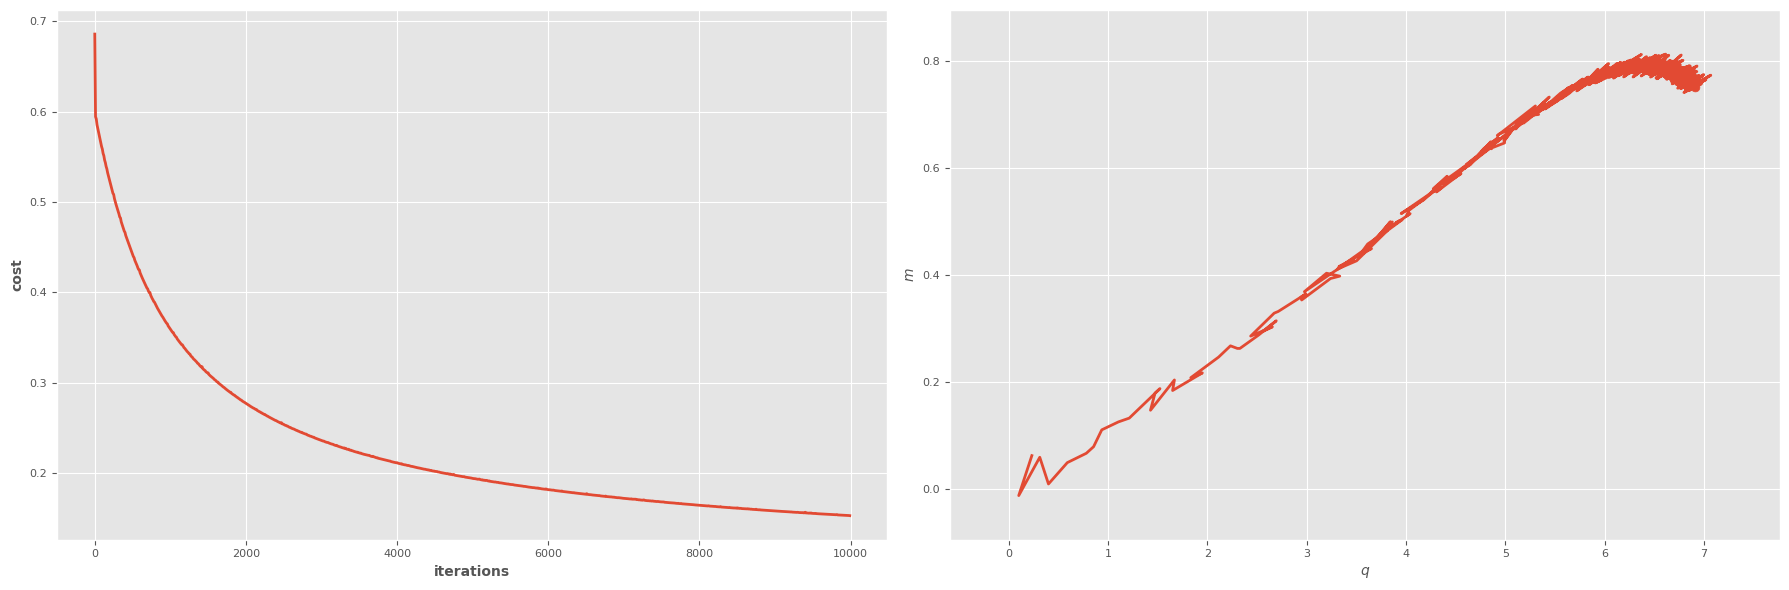

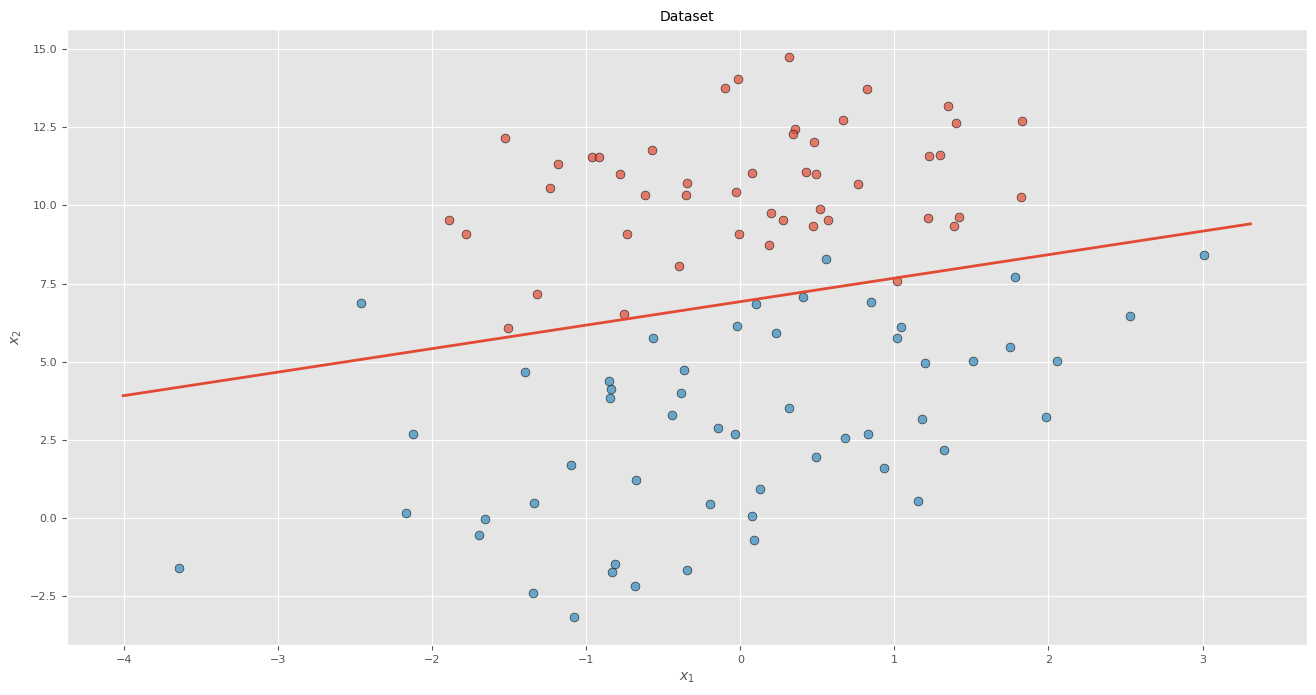

Valori stimati (Mini-Batch GD): m = 0.75155, q = 6.92064


In [ ]:
# ===============================================================
# 🧩 3️⃣ Mini-Batch Gradient Descent
# ===============================================================
# Variante intermedia: il gradiente viene calcolato su piccoli
# sottoinsiemi (mini-batch) del dataset, riducendo la varianza
# e mantenendo efficienza. La dimensione del batch è fissata a 10.
# ===============================================================

minibatch_size = 10

start_time = time.time()
cost_history_mb, theta_history_mb, m_mb, q_mb = mb_gd(X, t, eta=0.01, epochs=epochs, minibatch_size=minibatch_size)
time_mb = time.time() - start_time

# 📊 Risultati principali
print(f"Tempo di esecuzione (Mini-Batch GD): {time_mb:4.3f} s")
print(f"{len(m_mb)} passi effettuati ({epochs} epoche)")
print(f"{len(m_mb) * minibatch_size} gradienti calcolati ({minibatch_size} per passo)")
print(f"Valore finale della funzione di costo: {cost_history_mb[-1][0]:.4f}")

# 📈 Andamento del costo e traiettoria dei parametri
plot_all(cost_history_mb, m_mb, q_mb, step=10)

# 🔹 Retta di separazione finale sul dataset
plot_ds(data, m_mb[-1], q_mb[-1])

# 🔹 Visualizzazione dei valori ottimi stimati
print(f"Valori stimati (Mini-Batch GD): m = {m_mb[-1]:4.5f}, q = {q_mb[-1]:4.5f}")

## Considerazioni sul Mini-Batch Gradient Descent

---

### 🔹 Comportamento osservato

Il Mini-Batch Gradient Descent mostra un andamento **oscillante ma regolare**:
- gli aggiornamenti sono meno rumorosi rispetto allo SGD,  
- ma più veloci e leggeri rispetto al Batch GD.

La funzione di costo decresce progressivamente,  
pur con leggere fluttuazioni dovute alla natura stocastica dei mini-batch.

---

### 🔸 Vantaggi

- **Equilibrio** tra velocità e stabilità.  
- **Riduzione della varianza** del gradiente.  
- **Scalabile**: permette addestramento efficiente anche su dataset molto grandi.  
- **Ottimizzato per GPU**: i mini-batch consentono calcoli paralleli molto efficienti.

---

### ⚠️ Limiti

- La convergenza dipende dalla scelta della dimensione del batch:
  - batch troppo piccolo → rumore elevato;
  - batch troppo grande → aggiornamenti lenti.  
- Come per gli altri metodi, la scelta del *learning rate* rimane cruciale.

---

### 💡 In sintesi

| Aspetto | Batch GD | Stochastic GD | Mini-Batch GD |
|----------|-----------|----------------|----------------|
| Aggiornamento | Tutto il dataset | 1 campione | s campioni |
| Stabilità | Alta | Bassa | Media |
| Velocità | Lenta | Alta | Alta |
| Varianza del gradiente | Bassa | Alta | Media |
| Scalabilità | Bassa | Alta | Alta |
| Tipico uso | Dataset piccoli | Dataset enormi / online | Deep Learning |

---

📘 **Conclusione**  
Il Mini-Batch Gradient Descent è oggi lo **standard de facto** per l’addestramento di modelli complessi,  
poiché combina i vantaggi di entrambi gli approcci:  
è **veloce, stabile e facilmente parallelizzabile**.

### 📊 Confronto dei risultati

A questo punto possiamo confrontare in modo sintetico i tre metodi:  
- il **tempo di esecuzione**,  
- il **numero di passi** (cioè quante volte vengono aggiornati i parametri),  
- il **numero totale di gradienti calcolati**,  
- e il **valore finale della funzione di costo**.

Questo confronto ci permette di valutare **l’efficienza computazionale** e **la stabilità della convergenza** di ciascun approccio:

- **Batch GD** → più lento, ma con andamento regolare e stabile.  
- **SGD** → molto veloce negli aggiornamenti, ma con fluttuazioni più ampie.  
- **Mini-Batch GD** → compromesso efficace tra stabilità e rapidità.

In [ ]:
# ===============================================================
# 🧩 4️⃣ Confronto finale tra i tre metodi
# ===============================================================
# Riassumiamo tempo di esecuzione, passi, gradienti calcolati
# e costo finale per evidenziare le differenze di efficienza e stabilità.
# ===============================================================

print("\n=== 📊 CONFRONTO FINALE TRA I METODI ===")
print(f"{'Metodo':<18}{'Epoche':<8}{'Passi':<10}{'Gradienti':<15}{'Costo finale':<15}")
print("-"*65)
print(f"{'Batch GD':<18}{epochs:<8}{len(m_batch):<10}{len(m_batch):<15}{cost_history_batch[-1][0]:<15.4f}")
print(f"{'SGD':<18}{epochs:<8}{len(m_sgd):<10}{len(m_sgd):<15}{cost_history_sgd[-1][0]:<15.4f}")
print(f"{'Mini-Batch GD':<18}{epochs:<8}{len(m_mb):<10}{len(m_mb)*minibatch_size:<15}{cost_history_mb[-1][0]:<15.4f}")


=== 📊 CONFRONTO FINALE TRA I METODI ===
Metodo            Epoche  Passi     Gradienti      Costo finale   
-----------------------------------------------------------------
Batch GD          1000    1000      1000           0.1530         
SGD               1000    100000    100000         0.0987         
Mini-Batch GD     1000    10000     100000         0.1529         


---

## 🔎 Dulcis in fundo: come vanno questi metodi?

Abbiamo implementato e visualizzato tre varianti della **discesa del gradiente**:  
- Batch GD  
- Stochastic GD  
- Mini-Batch GD  

Abbiamo osservato tempi di esecuzione, numero di passi e andamento della funzione di costo.  
👉 Ora arriva la domanda più importante: **quanto bene predicono?**

Per rispondere, calcoliamo l’**accuratezza finale** dei modelli addestrati.  
Lo facciamo utilizzando i parametri $\theta$ stimati da ciascun metodo per predire le etichette del nostro dataset e confrontarle con i valori reali.  

⚠️ **Attenzione**: in questa fase stiamo misurando le performance **sullo stesso dataset usato per l’addestramento**.  
- Questo significa che la valutazione può risultare **ottimistica**.  
- In pratica dovremmo usare un **validation set** o una **cross-validation** per stimare correttamente le prestazioni su dati nuovi.  

Per ora, lo scopo è **confrontare i metodi di ottimizzazione tra loro**: vedremo se, oltre a convergere bene in termini di costo, arrivano anche a buoni risultati di classificazione.

---

In [ ]:
# ===============================================================
# 🧮 Funzione di predizione
# ===============================================================
def predict(theta, X, thr=0.5):
    """
    Predice la classe (0/1) per ciascun campione, dati i parametri theta.

    Passaggi:
    ----------
    1. Calcola la probabilità di appartenenza alla classe positiva (t=1)
       usando la funzione sigmoide: f(x; θ) = σ(Xθ).
    2. Confronta la probabilità con la soglia 'thr' (default 0.5):
       - se >= thr → classe 1
       - altrimenti → classe 0
    3. Restituisce un vettore binario con le predizioni.

    Parametri:
    ----------
    theta : ndarray (d x 1)
        Vettore dei parametri del modello (bias + pesi).
    X : ndarray (n x d)
        Matrice dei dati (inclusa la colonna di 1 per il bias).
    thr : float
        Soglia di decisione (default = 0.5).

    Ritorna:
    --------
    y_hat : ndarray (n x 1)
        Predizioni binarie (0 o 1).
    """
    probs = f(theta, X)                  # probabilità predette
    return (probs >= thr).astype(int)    # classi predette


# ===============================================================
# 🧩 5️⃣ Confronto finale con accuratezza di classificazione
# ===============================================================
# Oltre al costo finale, valutiamo anche l'accuratezza dei modelli
# ottenuti con Batch GD, SGD e Mini-Batch.
# ===============================================================

print("\n=== 📊 ACCURATEZZA FINALE DEI MODELLI ===")
print(f"{'Metodo':<18}{'Accuratezza':<12}")

# Batch GD
theta_final_batch = theta_history_batch[-1].reshape(-1,1)
y_hat_batch = predict(theta_final_batch, X)
acc_batch = (y_hat_batch == t).mean()
print(f"{'Batch GD':<18}{acc_batch:<12.3f}")

# SGD
theta_final_sgd = theta_history_sgd[-1].reshape(-1,1)
y_hat_sgd = predict(theta_final_sgd, X)
acc_sgd = (y_hat_sgd == t).mean()
print(f"{'SGD':<18}{acc_sgd:<12.3f}")

# Mini-Batch GD
theta_final_mb = theta_history_mb[-1].reshape(-1,1)
y_hat_mb = predict(theta_final_mb, X)
acc_mb = (y_hat_mb == t).mean()
print(f"{'Mini-Batch GD':<18}{acc_mb:<12.3f}")


=== 📊 ACCURATEZZA FINALE DEI MODELLI ===
Metodo            Accuratezza 
Batch GD          0.970       
SGD               0.950       
Mini-Batch GD     0.970       


# Algoritmi avanzati di ottimizzazione

I metodi di discesa del gradiente visti finora (batch, stochastic e mini-batch) rappresentano la base dell’ottimizzazione in Machine Learning. Tuttavia, nella pratica presentano limiti significativi: lenta convergenza, sensibilità al valore del learning rate e difficoltà in presenza di funzioni di costo complesse e non convesse.  

Per affrontare queste criticità, sono stati sviluppati diversi **metodi avanzati di ottimizzazione**, che introducono strategie aggiuntive per migliorare stabilità ed efficienza della discesa:  

- **Momento**: sfrutta l’inerzia dei passi precedenti per ridurre le oscillazioni e accelerare la convergenza.  
- **Nesterov Accelerated Gradient**: anticipa la direzione di aggiornamento, ottenendo un effetto più predittivo.  
- **Adagrad, RMSProp e Adadelta**: adattano dinamicamente il learning rate in base alla storia dei gradienti.  
- **Adam**: combina i vantaggi di momentum e adattività, diventando l’ottimizzatore più usato nelle reti neurali moderne.  
- **Metodi del secondo ordine**: sfruttano informazioni derivate dalla matrice Hessiana per una discesa più rapida e precisa.  

Nelle prossime lezioni analizzeremo questi approcci, a partire dal **metodo del momento**, per capire come affrontano i limiti delle tecniche elementari.


# 📝 Esercizi di approfondimento

In questa sezione troverai alcuni esercizi pratici per consolidare i concetti visti durante il laboratorio.  
Modifica il codice del notebook e osserva gli effetti delle tue scelte.  

---

## 1. Learning Rate

➡️ **Obiettivo:** capire come il learning rate (`eta`) influenza la convergenza.  

- Esegui il **Batch Gradient Descent** con:
  - `eta = 0.001`
  - `eta = 0.1`
  - `eta = 1.0`

📌 Domande:
1. Cosa succede al grafico della funzione di costo?
2. Perché con `eta` troppo grande l’algoritmo non converge?

---

## 2. Numero di epoche

➡️ **Obiettivo:** osservare l’effetto del numero di iterazioni.  

- Ripeti l’esperimento con **SGD** usando:
  - `epochs = 100`
  - `epochs = 1000`
  - `epochs = 10000`

📌 Domande:
1. Come cambia la stabilità del modello?
2. La funzione di costo si stabilizza? Dopo quante epoche?

---

## 3. Dimensione del mini-batch

➡️ **Obiettivo:** confrontare vari mini-batch.  

- Prova il **Mini-Batch GD** con:
  - `minibatch_size = 1` (equivalente a SGD)
  - `minibatch_size = 10`
  - `minibatch_size = n` (equivalente a Batch GD)

📌 Domande:
1. Come cambia il grafico della funzione di costo?
2. Quale compromesso ti sembra migliore?

---
